# PINN EIKONAL SOLVER

Imports, seed initialization and device configuration

In [1]:
import importlib

package_name = "skfmm"  
try:
    importlib.import_module(package_name)
    print(f"'{package_name}' is already installed.")
except ImportError:
    print(f"'{package_name}' not found. Installing...")
    !pip install scikit-fmm
    # Verify the installation
    try:
        importlib.import_module(package_name)
        print(f"'{package_name}' has been installed successfully.")
    except ImportError:
        print(f"Failed to import '{package_name}' even after installation!")

'skfmm' not found. Installing...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.9/465.9 kB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-fmm: filename=scikit_fmm-2024.9.16-cp310-cp310-linux_x86_64.whl size=77053 sha256=52dfa2641f0b9964291ff16ab6cb3067d8bb1d12e3f35f47fb71fa09fa971513
  Stored in directory: /root/.cache/pip/wheels/71/f4/c1/2813a009e5d5429b1220013c2103e49bf5115eae903954cd85
Successfully built scikit-fmm
'skfmm' has been installed successfully.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import random
from tqdm import tqdm
from torchinfo import summary
from mpl_toolkits.axes_grid1 import make_axes_locatable
import skfmm

torch.manual_seed(4321)     # PyTorch random number generator
np.random.seed(4321)    # Random number generations in other libraries
device = torch.device(1 if torch.cuda.is_available() else 'cpu') 
print(f"Device: {device}")

Device: cuda:1


In [3]:
"""Various Fisher information matrix approximations."""

from abc import ABC, abstractmethod
from typing import Union, List, Any, Dict
import copy

from numpy.linalg import inv, cholesky
import torch
from torch import Tensor
from torch.nn import Module, Sequential
import torch.nn.functional as F
from tqdm import tqdm


def get_eigenvectors(factors: Dict[Module, Tensor]) -> Dict[Module, Tensor]:
    """Computes the eigenvectors of KFAC factors.

    Args:
        factors: A dict mapping layers to lists of first and second KFAC factors.

    Returns:
        A dict mapping layers to lists containing the first and second KFAC factors eigenvectors.
    """
    eigenvectors = dict()
    for layer, (xxt, ggt) in factors.items():
        sym_xxt, sym_ggt = xxt + xxt.t(), ggt + ggt.t()
        _, xxt_eigvecs = torch.linalg.eigh(sym_xxt, UPLO='U')
        _, ggt_eigvecs = torch.linalg.eigh(sym_ggt, UPLO='U')
        eigenvectors[layer] = (xxt_eigvecs, ggt_eigvecs)
    return eigenvectors

def kron(a: Tensor,
         b: Tensor) -> Tensor:
    r"""Computes the Kronecker product between the two 2D-matrices (tensors) `a` and `b`.

    `Wikipedia example <https://en.wikipedia.org/wiki/Kronecker_product>`_.

    Args:
        a: A 2D-matrix
        b: A 2D-matrix

    Returns:
        The Kronecker product between `a` and `b`.

    Examples:
        >>> a = torch.tensor([[1, 2], [3, 4]])
        >>> b = torch.tensor([[0, 5], [6, 7]])
        >>> kron(a, b)
        tensor([[ 0,  5,  0, 10],
                [ 6,  7, 12, 14],
                [ 0, 15,  0, 20],
                [18, 21, 24, 28]])
    """
    return torch.einsum("ab,cd->acbd", [a, b]).contiguous().view(a.size(0) * b.size(0), a.size(1) * b.size(1))

class Curvature(ABC):
    """Base class for all src approximations.

    All src approximations are computed layer-wise (i.e. layer-wise independence is assumed s.t. no
    covariances between layers are computed, aka block-wise approximation) and stored in `state`.

    The src of the loss function is the matrix of 2nd-order derivatives of the loss w.r.t. the networks weights
    (i.e. the expected Hessian). It can be approximated by the expected Fisher information matrix and, under exponential
    family loss functions (like mean-squared error and cross-entropy loss) and piecewise linear activation functions
    (i.e. ReLU), becomes identical to the Fisher.

    Note:
        The aforementioned identity does not hold for the empirical Fisher, where the expectation is computed w.r.t.
        the data distribution instead of the models' output distribution. Also, because the latter is usually unknown,
        it is approximated through Monte Carlo integration using samples from a categorical distribution, initialized by
        the models' output.

    Source: `Optimizing Neural Networks with Kronecker-factored Approximate Curvature
    <https://arxiv.org/abs/1503.05671>`_
    """

    def __init__(self,
                 model: Union[Module, Sequential],
                 layer_types: Union[List[str], str] = None):
        """Curvature class initializer.

        Args:
            model: Any (pre-trained) PyTorch model including all `torchvision` models.
            layer_types: Types of layers for which to compute src information. Supported are `Linear`, `Conv2d`
                         and `MultiheadAttention`. If `None`, all supported types are considered. Default: None.
        """
        self.model = model
        self.model_state = copy.deepcopy(model.state_dict())
        self.layer_types = list()
        if isinstance(layer_types, str):
            self.layer_types.append(layer_types)
        elif isinstance(layer_types, list):
            if layer_types:
                self.layer_types.extend(layer_types)
            else:
                self.layer_types.extend(['Linear', 'Conv2d', 'MultiheadAttention'])
        elif layer_types is None:
            self.layer_types.extend(['Linear', 'Conv2d', 'MultiheadAttention'])
        else:
            raise TypeError
        for _type in self.layer_types:
            assert _type in ['Linear', 'Conv2d', 'MultiheadAttention']
        self.state = dict()
        self.inv_state = dict()

    @staticmethod
    def _replace(sample: Tensor,
                 weight: Tensor,
                 bias: Tensor = None):
        """Modifies current model parameters by adding/subtracting quantity given in `sample`.

        Args:
            sample: Sampled offset from the mean dictated by the inverse src (variance).
            weight: The weights of one model layer.
            bias: The bias of one model layer. Optional.
        """
        if bias is not None:
            bias_sample = sample[:, -1].contiguous().view(*bias.shape)
            bias.data.add_(bias_sample)
            sample = sample[:, :-1]
        weight.data.add_(sample.contiguous().view(*weight.shape))

    @abstractmethod
    def update(self, *args: Any, **kwargs: Any):
        """Abstract method to be implemented by each derived class individually."""
        raise NotImplementedError

    @abstractmethod
    def invert(self,
               add: Union[float, list, tuple] = 0.,
               multiply: Union[float, list, tuple] = 1.):
        """Abstract method to be implemented by each derived class individually. Inverts state.

        Args:
            add: This quantity times the identity is added to each src factor.
            multiply: Each factor is multiplied by this quantity.

        Returns:
            A dict of inverted factors and potentially other quantities required for sampling.
        """
        raise NotImplementedError

    @abstractmethod
    def sample(self,
               layer: Module) -> Tensor:
        """Abstract method to be implemented by each derived class individually. Samples from inverted state.

        Args:
            layer: A layer instance from the current model.

        Returns:
            A tensor with newly sampled weights for the given layer.
        """
        raise NotImplementedError

    def sample_and_replace(self):
        """Samples new model parameters and replaces old ones for selected layers, skipping all others."""
        self.model.load_state_dict(self.model_state)
        for layer in self.model.modules():
            if layer.__class__.__name__ in self.layer_types:
                if layer.__class__.__name__ in ['Linear', 'Conv2d']:
                    _sample = self.sample(layer)
                    self._replace(_sample, layer.weight, layer.bias)
                elif layer.__class__.__name__ == 'MultiheadAttention':
                    for weight, bias, layer in [(layer.in_proj_weight, layer.in_proj_bias, 'attn_in'),
                                                (layer.out_proj.weight, layer.out_proj.bias, 'attn_out')]:
                        _sample = self.sample(layer)
                        self._replace(_sample, weight, bias)

class Diagonal(Curvature):
    r"""The diagonal Fisher information or Generalized Gauss Newton matrix approximation.

    It is defined as :math:`F_{DIAG}=\mathrm{diag}(F)` with `F` being the Fisher defined in the `FISHER` class.
    Code inspired by https://github.com/wjmaddox/swa_gaussian/blob/master/swag/posteriors/diag_laplace.py.

    Source: `A Scalable Laplace Approximation for Neural Networks <https://openreview.net/pdf?id=Skdvd2xAZ>`_
    """

    def update(self,
               batch_size: int):
        """Computes the diagonal src for selected layer types, skipping all others.

        Args:
            batch_size: The size of the current batch.
        """
        for layer in self.model.modules():
            if layer.__class__.__name__ in self.layer_types:
                if layer.__class__.__name__ in ['Linear', 'Conv2d']:
                    grads = layer.weight.grad.contiguous().view(layer.weight.grad.shape[0], -1)
                    if layer.bias is not None:
                        grads = torch.cat([grads, layer.bias.grad.unsqueeze(dim=1)], dim=1)
                    grads = grads ** 2 * batch_size
                    if layer in self.state:
                        self.state[layer] += grads
                    else:
                        self.state[layer] = grads
                elif layer.__class__.__name__ == 'MultiheadAttention':
                    grads = layer.in_proj_weight.grad.contiguous().view(layer.in_proj_weight.grad.shape[0], -1)
                    grads = torch.cat([grads, layer.in_proj_bias.grad.unsqueeze(dim=1)], dim=1)
                    grads = grads ** 2 * batch_size
                    if 'attn_in' in self.state:
                        self.state['attn_in'] += grads
                    else:
                        self.state['attn_in'] = grads

                    grads = layer.out_proj.weight.grad.contiguous().view(layer.out_proj.weight.grad.shape[0], -1)
                    grads = torch.cat([grads, layer.out_proj.bias.grad.unsqueeze(dim=1)], dim=1)
                    grads = grads ** 2 * batch_size
                    if 'attn_out' in self.state:
                        self.state['attn_out'] += grads
                    else:
                        self.state['attn_out'] = grads

    def invert(self,
               add: Union[float, list, tuple] = 0.,
               multiply: Union[float, list, tuple] = 1.):
        assert self.state, "State dict is empty. Did you call 'update' prior to this?"
        if self.inv_state:
            Warning("State has already been inverted. Is this expected?")
        for index, (layer, value) in enumerate(self.state.items()):
            if isinstance(add, (list, tuple)) and isinstance(multiply, (list, tuple)):
                assert len(add) == len(multiply) == len(self.state)
                n, s = add[index], multiply[index]
            else:
                n, s = add, multiply
            self.inv_state[layer] = torch.reciprocal(s * value + n).sqrt()

    def sample(self,
               layer: Union[Module, str]):
        assert self.inv_state, "Inverse state dict is empty. Did you call 'invert' prior to this?"
        return self.inv_state[layer].new(self.inv_state[layer].size()).normal_() * self.inv_state[layer]

class KFAC(Curvature):
    r"""The Kronecker-factored Fisher information matrix approximation.

    For a single datum, the Fisher can be Kronecker-factorized into two much smaller matrices `Q` and `H`, aka
    `Kronecker factors`, s.t. :math:`F=Q\otimes H` where :math:`Q=zz^T` and :math:`H=\nabla_a^2 E(W)` with `z` being the
    output vector of the previous layer, `a` the `pre-activation` of the current layer (i.e. the output of the previous
    layer before being passed through the non-linearity) and `E(W)` the loss. For the expected Fisher,
    :math:`\mathbb{E}[Q\otimes H]\approx\mathbb{E}[Q]\otimes\mathbb{E}[H]` is assumed, which might not necessarily be
    the case.

    Code adapted from https://github.com/Thrandis/EKFAC-pytorch/kfac.py.

    Linear: `Optimizing Neural Networks with Kronecker-factored Approximate Curvature
    <https://arxiv.org/abs/1503.05671>`_

    Convolutional: `A Kronecker-factored approximate Fisher matrix for convolutional layers
    <https://arxiv.org/abs/1602.01407>`_
    """
    def __init__(self,
                 model: Union[Module, Sequential],
                 layer_types: Union[List[str], str] = None):
        """KFAC class initializer.

        For the recursive computation of `H`, outputs and inputs for each layer are recorded in `record`. Forward and
        backward hook handles are stored in `hooks` for subsequent removal.

        Args:
            model: Any (pre-trained) PyTorch model including all `torchvision` models.
        """
        super().__init__(model, layer_types)
        self.hooks = list()
        self.record = dict()

        for layer in model.modules():
            if layer.__class__.__name__ in self.layer_types:
                if layer.__class__.__name__ in ['Linear', 'Conv2d']:
                    self.record[layer] = [None, None]
                    self.hooks.append(layer.register_forward_pre_hook(self._save_input))
                    self.hooks.append(layer.register_full_backward_hook(self._save_output))
                elif layer.__class__.__name__ == 'MultiheadAttention':
                    raise NotImplementedError

    def _save_input(self, module, input):
        self.record[module][0] = input[0]

    def _save_output(self, module, grad_input, grad_output):
        self.record[module][1] = grad_output[0] * grad_output[0].size(0)

    def update(self,
               batch_size: int):
        """Computes the 1st and 2nd Kronecker factor `Q` and `H` for each selected layer type, skipping all others.

        Todo: Check code against papers.

        Args:
            batch_size: The size of the current batch.
        """
        for layer in self.model.modules():
            module_class = layer.__class__.__name__
            if layer.__class__.__name__ in self.layer_types:
                if module_class in ['Linear', 'Conv2d']:
                    forward, backward = self.record[layer]

                    # 1st factor: Q
                    if module_class == 'Conv2d':
                        forward = F.unfold(forward, layer.kernel_size, padding=layer.padding, stride=layer.stride)
                        forward = forward.data.permute(1, 0, 2).contiguous().view(forward.shape[1], -1)
                    else:
                        forward = forward.data.t()
                    if layer.bias is not None:
                        ones = torch.ones_like(forward[:1])
                        forward = torch.cat([forward, ones], dim=0)
                    first_factor = torch.mm(forward, forward.t()) / float(forward.shape[1])

                    # 2nd factor: H
                    if module_class == 'Conv2d':
                        backward = backward.data.permute(1, 0, 2, 3).contiguous().view(backward.shape[1], -1)
                    else:
                        backward = backward.data.t()
                    second_factor = torch.mm(backward, backward.t()) / float(backward.shape[1])

                    # Expectation
                    if layer in self.state:
                        self.state[layer][0] += first_factor
                        self.state[layer][1] += second_factor
                    else:
                        self.state[layer] = [first_factor, second_factor]
                elif layer.__class__.__name__ == 'MultiheadAttention':
                    raise NotImplementedError

    def invert(self,
               add: Union[float, list, tuple] = 0.,
               multiply: Union[float, list, tuple] = 1.):
        assert self.state, "State dict is empty. Did you call 'update' prior to this?"
        if self.inv_state:
            Warning("State has already been inverted. Is this expected?")
        for index, (layer, value) in enumerate(self.state.items()):
            if not isinstance(add, (float, int)) and not isinstance(multiply, (float, int)):
                assert len(add) == len(multiply) == len(self.state)
                n, s = add[index], multiply[index]
            else:
                n, s = float(add), float(multiply)
            first, second = value

            diag_frst = torch.diag(first.new(first.shape[0]).fill_(n ** 0.5))
            diag_scnd = torch.diag(second.new(second.shape[0]).fill_(n ** 0.5))

            reg_frst = s ** 0.5 * first + diag_frst
            reg_scnd = s ** 0.5 * second + diag_scnd

            reg_frst = (reg_frst + reg_frst.t()) / 2.0
            reg_scnd = (reg_scnd + reg_scnd.t()) / 2.0

            try:
                chol_ifrst = reg_frst.inverse().cholesky()
                chol_iscnd = reg_scnd.inverse().cholesky()
            except RuntimeError:
                print("PyTorch Cholesky is singular. Using Numpy.")
                chol_ifrst = torch.from_numpy(cholesky(inv(reg_frst.cpu().numpy()))).to(first.device)
                chol_iscnd = torch.from_numpy(cholesky(inv(reg_scnd.cpu().numpy()))).to(second.device)

            self.inv_state[layer] = (chol_ifrst, chol_iscnd)

    def sample(self,
               layer: Module) -> Tensor:
        assert self.inv_state, "Inverse state dict is empty. Did you call 'invert' prior to this?"
        first, second = self.inv_state[layer]
        z = torch.randn(first.size(0), second.size(0), device=first.device, dtype=first.dtype)
        return (first @ z @ second.t()).t()  # Final transpose because PyTorch uses channels first

class EFB(Curvature):
    """The eigenvalue corrected Kronecker-factored Fisher information or Generalized Gauss Newton matrix.

    Todo: Add source/equations.
    """
    def __init__(self,
                 model: Union[Module, Sequential],
                 factors: Dict[Module, Tensor],
                 layer_types: Union[List[str], str] = None):
        """EFB class initializer.

        Args:
            model: Any (pre-trained) PyTorch model including all `torchvision` models.
            factors: The Kronecker factors Q and H, computed using the `KFAC` class.
        """
        super().__init__(model, layer_types)
        self.eigvecs = get_eigenvectors(factors)
        self.diags = dict()

    def update(self,
               batch_size: int):
        """Computes the eigenvalue corrected diagonal of the FiM or GNN.

        Args:
            batch_size: The size of the current batch.
        """
        for layer in self.model.modules():
            if layer.__class__.__name__ in self.layer_types:
                if layer.__class__.__name__ in ['Linear', 'Conv2d']:
                    grads = layer.weight.grad.contiguous().view(layer.weight.grad.shape[0], -1)
                    if layer.bias is not None:
                        grads = torch.cat([grads, layer.bias.grad.unsqueeze(dim=1)], dim=1)
                    lambdas = (self.eigvecs[layer][1].t() @ grads @ self.eigvecs[layer][0]) ** 2

                    if layer in self.state:
                        self.state[layer] += lambdas
                        self.diags[layer] += grads ** 2 * batch_size
                    else:
                        self.state[layer] = lambdas
                        self.diags[layer] = grads ** 2 * batch_size
                elif layer.__class__.__name__ == 'MultiheadAttention':
                    raise NotImplementedError

    def invert(self,
               add: Union[float, list, tuple] = 0.,
               multiply: Union[float, list, tuple] = 1.):
        assert self.state, "State dict is empty. Did you call 'update' prior to this?"
        if self.inv_state:
            Warning("State has already been inverted. Is this expected?")
        for index, (layer, value) in enumerate(self.state.items()):
            if not isinstance(add, float) and not isinstance(multiply, float):
                assert len(add) == len(multiply) == len(self.state)
                n, s = add[index], multiply[index]
            else:
                n, s = add, multiply
            reg_inv_lambda = torch.reciprocal(s * value + n).sqrt()
            self.inv_state[layer] = reg_inv_lambda

    def sample(self,
               layer: Module) -> Tensor:
        assert self.inv_state, "Inverse state dict is empty. Did you call 'invert' prior to this?"
        first, second = self.eigvecs[layer]
        lambdas = self.inv_state[layer]
        z = torch.randn(first.size(0), second.size(0), device=first.device, dtype=first.dtype)
        z *= lambdas.t()
        return (first @ z @ second.t()).t()  # Final transpose because PyTorch uses channels first

class INF(Curvature):
    """Computes the diagonal correction term and low-rank approximations of KFAC factor eigenvectors and EFB diagonals.

    Todo: Add more info from paper.
    """
    def __init__(self,
                 model: Union[Module, Sequential],
                 diags: Dict[Module, Tensor],
                 factors: Dict[Module, Tensor],
                 lambdas: Dict[Module, Tensor],
                 layer_types: Union[List[str], str] = None):
        """INF class initializer.

        Args:
            diags: Diagonal FiM or GNN computed by `Diagonal` class.
            factors: Kronecker-factored FiM or GNN computed by `KFAC` class.
            lambdas: Eigenvalue corrected diagonal FiM or GNN computed by `EFB` class.
        """
        super().__init__(model, layer_types)
        assert diags.keys() == factors.keys() == lambdas.keys()
        self.eigvecs = get_eigenvectors(factors)
        self.lambdas = lambdas
        self.diags = diags

    def update(self,
               rank: int = 100):
        """Accumulates the diagonal values used for the diagonal correction term.

        Todo: Add more info from paper.
        Args:
            rank: The rank of the low-rank approximations.
        """
        values = zip(list(self.diags.keys()),
                     list(self.eigvecs.values()),
                     list(self.lambdas.values()),
                     list(self.diags.values()))
        for layer, eigvecs, lambdas, diags in tqdm(values, total=len(self.diags)):
            xxt_eigvecs, ggt_eigvecs = eigvecs
            lambda_vec = lambdas.t().contiguous().view(-1)
            diag_vec = diags.t().contiguous().view(-1)

            lr_xxt_eigvecs, lr_ggt_eigvecs, lr_lambda = self._dim_reduction(xxt_eigvecs, ggt_eigvecs, lambda_vec, rank)
            sif_diag = self._diagonal_accumulator(lr_xxt_eigvecs, lr_ggt_eigvecs, lr_lambda)

            self.state[layer] = (lr_xxt_eigvecs, lr_ggt_eigvecs, lr_lambda, diag_vec - sif_diag)

    def invert(self,
               add: Union[float, list, tuple] = 0.,
               multiply: Union[float, list, tuple] = 1.):
        assert self.state, "State dict is empty. Did you call 'update' prior to this?"
        if self.inv_state:
            Warning("State has already been inverted. Is this expected?")
        for index, (layer, value) in enumerate(self.state.items()):
            if not isinstance(add, float) and not isinstance(multiply, float):
                assert len(add) == len(multiply) == len(self.state)
                n, s = add[index], multiply[index]
            else:
                n, s = add, multiply
            # Low-rank U_A, low-rank U_G, low-rank Lambda, D
            lr_frst_eigvecs, lr_scnd_eigvecs, lr_lambda, correction = value
            correction[correction < 0] = 0

            reg_lr_lambda = (s * lr_lambda).sqrt()
            reg_inv_correction = torch.reciprocal(s * correction + n).sqrt()

            pre_sample = self.pre_sampler(lr_frst_eigvecs, lr_scnd_eigvecs, reg_lr_lambda, reg_inv_correction)

            self.inv_state[layer] = (lr_frst_eigvecs, lr_scnd_eigvecs, reg_inv_correction, pre_sample)

    def sample(self,
               layer: Module) -> Tensor:
        assert self.inv_state, "Inverse state dict is empty. Did you call 'invert' prior to this?"
        a, b, c, d = self.inv_state[layer]
        return self.sampler(a, b, c, d).reshape(a.shape[0], b.shape[0]).t()

    @staticmethod
    def pre_sampler(frst_eigvecs: torch.Tensor,
                    scnd_eigvecs: torch.Tensor,
                    reg_lambda: torch.Tensor,
                    reg_inv_correction: torch.Tensor) -> torch.Tensor:
        """Pre-sampler for INF sampling. Only needs to be called once.

        Args:
            frst_eigvecs: Eigenvectors of first KFAC factor.
            scnd_eigvecs: Eigenvectors of second KFAC factor.
            reg_lambda: Regularized, eigenvalue corrected diagonal FIM (computed by EFB)
            reg_inv_correction: Regularized inverse of the diagonal correction term of INF.

        Returns:
            A pre-sample used in `sampler` to sample weight sets.
        """
        scale_sqrt = torch.diag(reg_lambda)
        try:
            V_s = reg_inv_correction.contiguous().view(-1, 1) * kron(frst_eigvecs, scnd_eigvecs) @ scale_sqrt
        except RuntimeError:
            print("GPU capacity exhausted. Pre-sampling on CPU.")
            frst_eigvecs = frst_eigvecs.cpu()
            scnd_eigvecs = scnd_eigvecs.cpu()
            reg_inv_correction = reg_inv_correction.cpu()
            scale_sqrt = scale_sqrt.cpu()
            V_s = reg_inv_correction.contiguous().view(-1, 1) * kron(frst_eigvecs, scnd_eigvecs) @ scale_sqrt
        vtv = V_s.t() @ V_s
        vtv = (vtv + vtv.t()) / 2.
        A_c_inv = vtv.cholesky().inverse()
        B_c = (vtv + torch.eye(scale_sqrt.shape[0], device=scale_sqrt.device)).cholesky()
        C = A_c_inv.t() @ (B_c - torch.eye(scale_sqrt.shape[0], device=scale_sqrt.device)) @ A_c_inv
        L_c = (C.inverse() + vtv).inverse()
        P_c = scale_sqrt @ L_c @ scale_sqrt

        return P_c.to(reg_lambda.device)

    @staticmethod
    def sampler(frst_eigvecs: Tensor,
                scnd_eigvecs: Tensor,
                reg_inv_correction: Tensor,
                pre_sample: Tensor) -> Tensor:
        """Samples a new set of weights from the INF weight posterior distribution for the current layer.

        Args:
            frst_eigvecs: Eigenvectors of first KFAC factor.
            scnd_eigvecs: Eigenvectors of second KFAC factor.
            reg_inv_correction: Regularized inverse of the diagonal correction term of INF.
            pre_sample: Pre-sample computed by the pre-sampler.

        Returns:
            A new set of weights for the current layer.
        """
        X = torch.randn(frst_eigvecs.shape[0] * scnd_eigvecs.shape[0], device=frst_eigvecs.device,
                        dtype=frst_eigvecs.dtype)
        Y_l = reg_inv_correction * X
        unvec_Y_l = Y_l.t().reshape((scnd_eigvecs.shape[0], frst_eigvecs.shape[0]))
        Xq = scnd_eigvecs.t() @ unvec_Y_l @ frst_eigvecs
        Qx = pre_sample @ Xq.t().contiguous().view(-1)
        unvec_Qx = Qx.t().reshape((scnd_eigvecs.shape[1], frst_eigvecs.shape[1]))
        X_p_s = scnd_eigvecs @ unvec_Qx @ frst_eigvecs.t()
        Y_r = reg_inv_correction ** 2 * X_p_s.t().contiguous().view(-1)

        return Y_l.t() - Y_r.t()

    @staticmethod
    def _dim_reduction(frst_eigvecs: Tensor,
                       scnd_eigvecs: Tensor,
                       lambda_vec: Tensor,
                       rank: int):
        """

        Args:
            frst_eigvecs:
            scnd_eigvecs:
            lambda_vec:
            rank:

        Returns:

        """
        if rank >= lambda_vec.shape[0]:
            return frst_eigvecs, scnd_eigvecs, lambda_vec
        else:
            m = scnd_eigvecs.shape[1]
            idx_total_0 = torch.argsort(-torch.abs(lambda_vec))
            idx_total = idx_total_0 + 1
            idx_top_l = idx_total[0:rank]
            idx_left = list()
            idx_right = list()
            for z in range(rank):
                i = int((idx_top_l[z] - 1.) / m + 1.)
                j = idx_top_l[z] - (m * (i - 1))
                idx_left.append(i)
                idx_right.append(j)

            idx_top_lm = list()
            idx_left = torch.unique(torch.tensor(idx_left))
            idx_right = torch.unique(torch.tensor(idx_right))
            len_l = len(idx_left)
            len_r = len(idx_right)

            for i in range(0, len_l):
                for j in range(0, len_r):
                    idx_top_lm.append(m * (idx_left[i] - 1) + idx_right[j])

            lr_lambda = lambda_vec[[idx - 1 for idx in idx_top_lm]]
            lr_cov_inner = frst_eigvecs[:, [idx - 1 for idx in idx_left]]
            lr_cov_outer = scnd_eigvecs[:, [idx - 1 for idx in idx_right]]

            return lr_cov_inner, lr_cov_outer, lr_lambda

    @staticmethod
    def _diagonal_accumulator(xxt_eigvecs: Tensor,
                              ggt_eigvecs: Tensor,
                              lambda_vec: Tensor):
        """

        Args:
            xxt_eigvecs:
            ggt_eigvecs:
            lambda_vec:

        Returns:

        """
        n = xxt_eigvecs.shape[0]
        m = ggt_eigvecs.shape[0]
        diag_vec = torch.zeros(n * m).to(lambda_vec.device)
        k = 0

        for i in range(n):
            diag_kron = kron(xxt_eigvecs[i, :].unsqueeze(0), ggt_eigvecs) ** 2
            diag_vec[k:k + m] = diag_kron @ lambda_vec
            k += m
        return diag_vec

## Physical Informed Neural Network definition
PINNs rely on fully-connected neural network

In [4]:
class PINN(nn.Module):
    def __init__(self, init='kaiming_normal'):
        super().__init__()
        self.linears = nn.Sequential(
                        nn.Linear(3,16),
                        nn.Mish(),
                        nn.Linear(16,16),
                        nn.Mish(),
                        nn.Linear(16,32),
                        nn.Mish(),
                        nn.Linear(32,32),
                        nn.Mish(),
                        nn.Linear(32,16),
                        nn.Mish(),
                        nn.Linear(16,16),
                        nn.Mish(),
                        nn.Linear(16, 1),
                        )
        self.model_initialization(init)

    def model_initialization(self, init='kaiming_normal'):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight)
                    nn.init.constant_(m.bias, 0)
                elif init == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                    nn.init.constant_(m.bias, 0)
                elif init == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0) 
                elif init == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0)
                else:
                    raise NotImplementedError("I'm lazy to implement.")

    # forward propagation
    def forward(self, x):
        return self.linears(x)

## LOSS
The Loss function is what makes this Neural Network physically informed.

In [5]:
class LossEikonal(nn.Module):
  """
  Create a loss function for Eikonal equation 
  physics informed neural network (PINN).

  Attributes:
    model: PINN model
    T0: smooth background travel time.
    px0: smooth background travel time derivative w.r.t x
    pz0: smooth background travel time derivative w.r.t z
    vel: smooth background velocity model
    sids: source indices
  """

  def __init__(self):
    super().__init__()
    self.loss = nn.MSELoss()

  def forward(self, model, params):
    """
    Compute loss function for Eikonal equation 
    physics informed neural network (PINN).

    Args:
      tau: the PINN predictions
      dataset: current dataset

    Returns:
      loss: Tensor of loss value
    """
    
    vel = params['vel']
    inputs = params['input']
    data_pts = params['data_pts']
    data = params['data']

    # compute derivative of tau
    tau = model(inputs)
    tau_data = model(data_pts)

    g = ag.grad(outputs=tau, inputs=inputs, 
                grad_outputs=torch.ones_like(tau), create_graph=True)[0]

    dtau_dz = g[..., 2].reshape(-1, 1)
    dtau_dx = g[..., 0].reshape(-1, 1)
    dtau_dy = g[..., 1].reshape(-1, 1)

    # Compute Eikonal loss
    loss_eqn = self.loss(
        dtau_dz**2 + dtau_dx**2 + dtau_dy**2,
        1.0 / (vel**2)
    )

    # Compute Eikonal equation solution constraint with Heaviside function
    loss_heav = self.loss(
        (1 - torch.sign(tau)) * torch.abs(tau),
        torch.zeros_like(tau)
    )

    # Compute source constraint for Eikonal equation
    loss_data = self.loss(tau_data, data)

    return loss_eqn + loss_data + loss_heav, loss_eqn, loss_data

## Velocity Model
First let's consider an artificial 3d model(300x300x300)

In [6]:
# Define the dimensions of the 3D model
nx, ny, nz = 300, 300, 300  # Grid size (X, Y, Z)
xmin, xmax = 0, 10  # X limits
ymin, ymax = 0, 10  # Y limits
zmin, zmax = 0, 10  # Z limits
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
z = np.linspace(zmin, zmax, nz)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
delta_z = z[1] - z[0]

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Define velocity variations
# Base velocity with sinusoidal layering
velocity_base = 1500 + 300 * np.sin(2 * np.pi * Z / np.max(Z) + np.pi * X / np.max(X))

# Add Gaussian inclusions (e.g., pockets)
gaussian_1 = 500 * np.exp(-((X - 5) ** 2 + (Y - 5) ** 2 + (Z - 2) ** 2))
gaussian_2 = -400 * np.exp(-((X - 7) ** 2 + (Y - 3) ** 2 + (Z - 7) ** 2))
gaussian_3 = 300 * np.exp(-((X - 3) ** 2 + (Y - 8) ** 2 + (Z - 5) ** 2))

# Linearly increasing velocity with depth
velocity_depth = 200 * Z / np.max(Z)

# Combine features
velocity_model_3d = velocity_base + gaussian_1 + gaussian_2 + gaussian_3 + velocity_depth
velocity_model_3d = velocity_model_3d / 1000.0

In [ ]:
# Display several slices over the 3D model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Slice at the middle of the X dimension
slice_x = velocity_model_3d[nx//2, :, :]
im1 = axes[0].imshow(slice_x, extent=[0, 10, 0, 10], origin='lower')
axes[0].set_title('Slice at X middle')
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Slice at the middle of the Y dimension
slice_y = velocity_model_3d[:, ny//2, :]
im2 = axes[1].imshow(slice_y, extent=[0, 10, 0, 10], origin='lower')
axes[1].set_title('Slice at Y middle')
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

# Slice at the middle of the Z dimension
slice_z = velocity_model_3d[:, :, nz//2]
im3 = axes[2].imshow(slice_z, extent=[0, 10, 0, 10], origin='lower')
axes[2].set_title('Slice at Z middle')
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)

plt.show()

# Generate the Dataset 
Create the grid with the reference traveltimes and select the source location

Source location: (9.799331103678929, 7.759197324414715, 7.424749163879598)


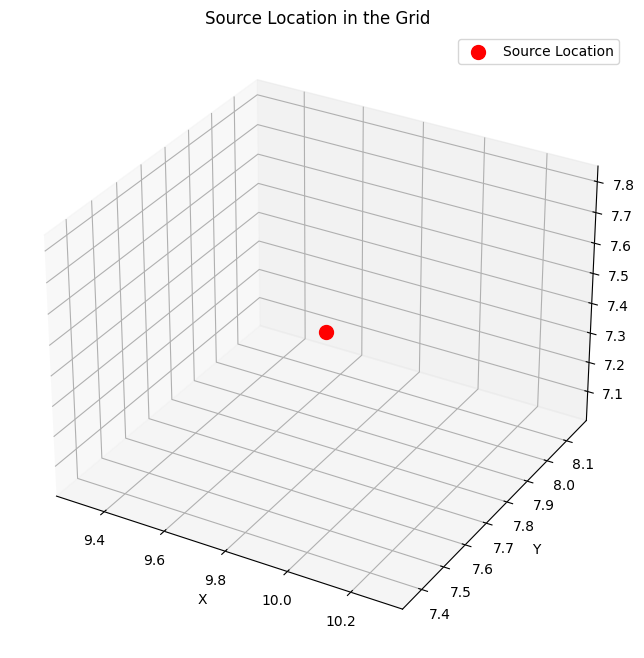

In [8]:
# Define the source location
source_location = (random.choice(x), random.choice(y), random.choice(z))
print(f"Source location: {source_location}")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(source_location[0], source_location[1], source_location[2], color='r', s=100, label='Source Location')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Source Location in the Grid')
ax.legend()
plt.show()

In [12]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

Display the velocity model with the source location

In [13]:
# Travel-time solution
phi = np.ones_like(velocity_model_3d)
source_idx = (int(source_location[0] // delta_x), int(source_location[1] // delta_y), int(source_location[2] // delta_z))
phi[source_idx] = -1.  # Initialize the source location with impossible phi value

T_data = skfmm.travel_time(phi, velocity_model_3d, dx=(delta_x, delta_y, delta_z))

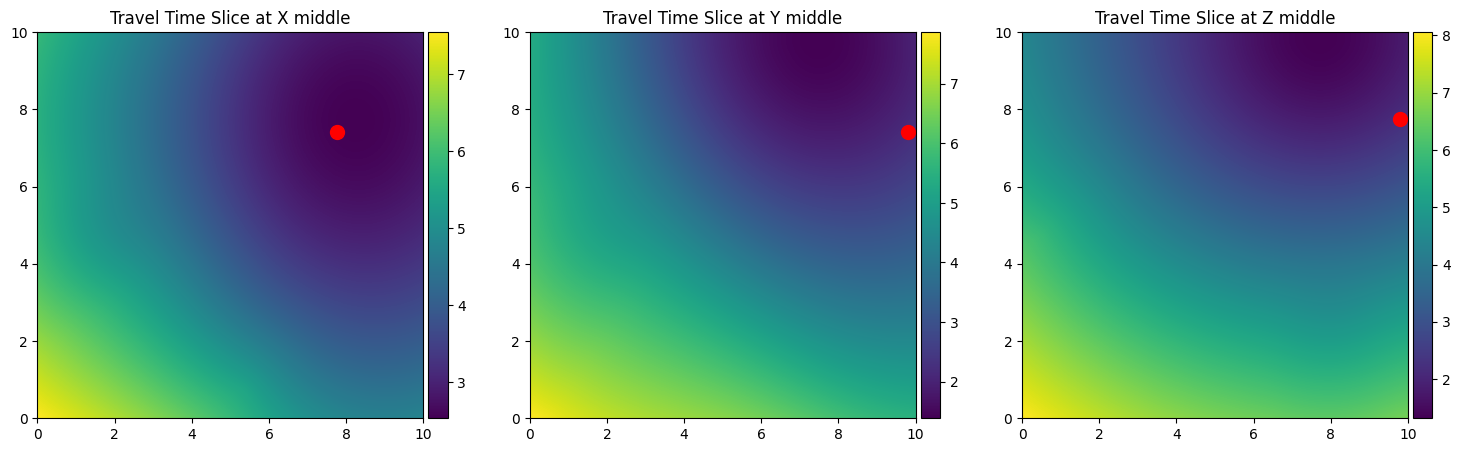

In [14]:
# Plot slices of the travel time T_data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Slice at the middle of the X dimension
slice_x = T_data[nx // 2, :, :]
im1 = axes[0].imshow(slice_x, extent=[xmin, xmax, ymin, ymax], origin='lower')
axes[0].scatter(source_location[1], source_location[2], color='r', s=100, label='Source Location')
axes[0].set_title('Travel Time Slice at X middle')
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

# Slice at the middle of the Y dimension
slice_y = T_data[:, ny // 2, :]
im2 = axes[1].imshow(slice_y, extent=[xmin, xmax, zmin, zmax], origin='lower')
axes[1].scatter(source_location[0], source_location[2], color='r', s=100, label='Source Location')
axes[1].set_title('Travel Time Slice at Y middle')
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

# Slice at the middle of the Z dimension
slice_z = T_data[:, :, nz // 2]
im3 = axes[2].imshow(slice_z, extent=[xmin, xmax, ymin, ymax], origin='lower')
axes[2].scatter(source_location[0], source_location[1], color='r', s=100, label='Source Location')
axes[2].set_title('Travel Time Slice at Z middle')
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax3)

plt.show()
T_data = torch.from_numpy(T_data).float().to(device)

In [15]:
X,Y,Z = torch.meshgrid(torch.linspace(xmin, xmax, nx), torch.linspace(ymin, ymax, ny), torch.linspace(zmin, zmax, nz))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Define the receivers

In [16]:
n_receivers = 1000
# Generate random x and y coordinates for receivers
x_receivers = np.random.uniform(xmin, xmax, n_receivers)
y_receivers = np.random.uniform(ymin, ymax, n_receivers)
z_receivers = np.ones_like(x_receivers) * zmax  

# Create tensor of receiver positions
receivers_grid_positions = torch.tensor(np.column_stack((x_receivers, y_receivers, z_receivers)), 
                                     dtype=torch.float32, 
                                     device=device)

receivers_idx = []
for i in range(len(x_receivers)):
    idx_x = (abs(x - x_receivers[i])).argmin()
    idx_y = (abs(y - y_receivers[i])).argmin()
    idx_z = (abs(z - z_receivers[i])).argmin()
    receivers_idx.append((idx_x, idx_y, idx_z))

# Get travel times for receiver positions
receivers_travel_times = torch.tensor([[T_data[idx]] for idx in receivers_idx], 
                                    dtype=torch.float32, 
                                    device=device)

# Convert receivers grid positions to tensor
receivers_tensor = receivers_grid_positions.requires_grad_(False)

In [17]:
n_training_points = 100000 
# Define random training points
print(f"X type: {type(X)}")
training_points = np.random.choice(np.arange(Z.numel()), n_training_points, replace=False)
X_trainings = X.reshape(-1, 1)[training_points]
Y_trainings = Y.reshape(-1, 1)[training_points]
Z_trainings = Z.reshape(-1, 1)[training_points]

# Define the Travel Times velocity solutions
velocities = torch.from_numpy(velocity_model_3d).float().to(device)
velocities = velocities.reshape(-1, 1)[training_points].requires_grad_(False).to(device)

# Finally define the torch tensor for the training points
training_points = torch.hstack((X_trainings, Y_trainings, Z_trainings)).requires_grad_(True).to(device)

# grid points for predictions
prediction_grid = torch.hstack((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1))).to(device)

params = {'vel': velocities, 'input': training_points, 'data_pts':receivers_tensor, 'data':receivers_travel_times}

X type: <class 'torch.Tensor'>


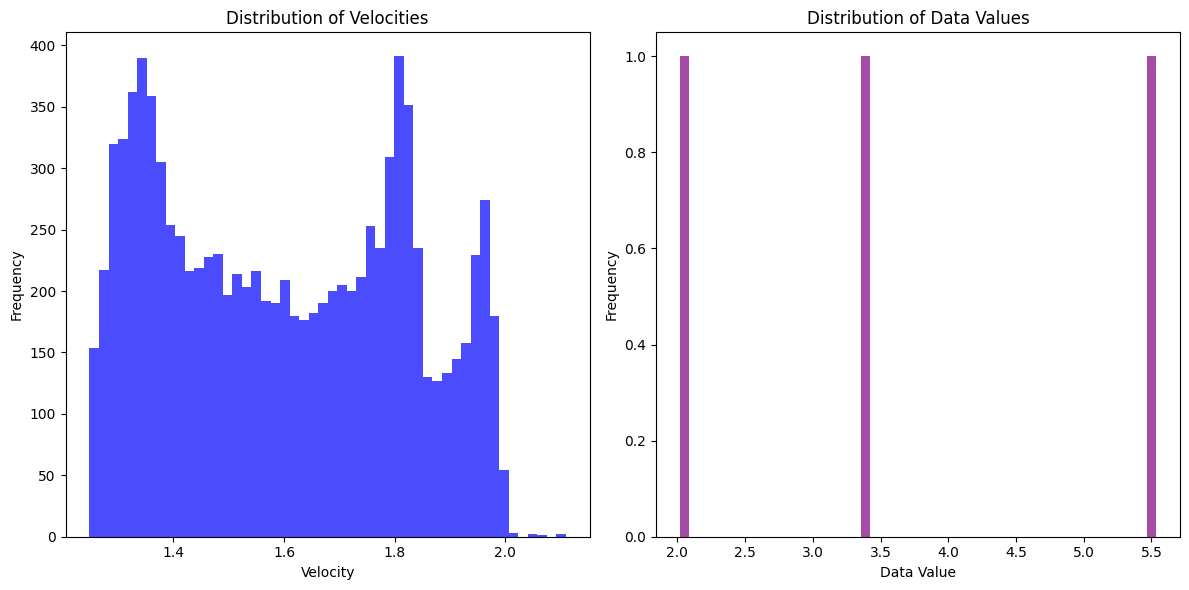

In [ ]:
# # Print initialization type
# print(f"Initialization type: {initialization}")
# print(f"params['vel'] shape: {params['vel'].shape}")
# print(f"params['input'] shape: {params['input'].shape}")
# print(f"params['data_pts'] shape: {params['data_pts'].shape}")
# print(f"params['data'] shape: {params['data'].shape}")

# for key, value in params.items():
#     if isinstance(value, torch.Tensor):
#         print(f"\nFirst few elements of {key}:")
#         if key == 'vel':
#             print(value[:5])  # First 5 velocity values
#         elif key == 'input':
#             print(value[:5])  # First 5 input points (z,x,y coordinates)
#         elif key == 'data_pts':
#             print(value[:5])  # First 5 data points
#         elif key == 'data': 
#             print(value[:5])  # First 5 data values
# # Plot distributions of vel, input, data_pts, and data
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Distribution of velocities
axes[0].hist(params['vel'].cpu().numpy(), bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribution of Velocities')
axes[ 0].set_xlabel('Velocity')
axes[ 0].set_ylabel('Frequency')


# Distribution of data values
axes[1].hist(params['data'].cpu().numpy().flatten(), bins=50, color='purple', alpha=0.7)
axes[1].set_title('Distribution of Data Values')
axes[1].set_xlabel('Data Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 6))

# Plot 3D distribution of input points
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(params['input'][:, 0].cpu().detach().numpy(), params['input'][:, 1].cpu().detach().numpy(), params['input'][:, 2].cpu().detach().numpy(), c='blue', marker='o', s=1, alpha=0.6)
ax1.set_title('3D Distribution of Input Points')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot 3D distribution of data points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(params['data_pts'][:, 0].cpu().detach().numpy(), params['data_pts'][:, 1].cpu().detach().numpy(), params['data_pts'][:, 2].cpu().detach().numpy(), c='red', marker='o', s=1, alpha=0.6)
ax2.set_title('3D Distribution of Data Points')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [19]:
def save_checkpoint(model, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
    }
    torch.save(checkpoint, filename)
    
def load_checkpoint(checkpoint_file, model):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cpu")
    model.load_state_dict(checkpoint["state_dict"])

# initialize PINN model and summary
initialization = 'kaiming_normal'
pinn = PINN(init=initialization).to(device)
pinn.train()
# initialize system
system = LossEikonal()
diag = Diagonal(pinn)
kfac = KFAC(pinn)
summary(pinn)

Layer (type:depth-idx)                   Param #
PINN                                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       64
│    └─Mish: 2-2                         --
│    └─Linear: 2-3                       272
│    └─Mish: 2-4                         --
│    └─Linear: 2-5                       544
│    └─Mish: 2-6                         --
│    └─Linear: 2-7                       1,056
│    └─Mish: 2-8                         --
│    └─Linear: 2-9                       528
│    └─Mish: 2-10                        --
│    └─Linear: 2-11                      272
│    └─Mish: 2-12                        --
│    └─Linear: 2-13                      17
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0

In [20]:
# maximum iterations
max_iter = 100000
total_loss = np.zeros((max_iter)) 
eqn_loss = np.zeros((max_iter)) 
data_loss = np.zeros((max_iter)) 


# Adam Optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=5e-3, betas=(0.5, 0.9))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       max_iter, 
                                                       eta_min=0, 
                                                       last_epoch=- 1, 
                                                       verbose=False)

# training start
iterations = tqdm(range(max_iter))
start_time = time.time()
for j in iterations:
    loss, loss_eq, loss_data = system(pinn, params)
    

    loss.backward()
    optimizer.step()
    scheduler.step()
    diag.update(batch_size=n_training_points)
    kfac.update(batch_size=n_training_points)
    efb = EFB(pinn, kfac.state)
    efb.update(batch_size=n_training_points)
    optimizer.zero_grad()

    total_loss[j] = loss.item()
    eqn_loss[j] = loss_eq.item()
    data_loss[j] = loss_data.item()
    iterations.set_postfix(loss=loss.item())

elapsed = time.time() - start_time                
print('\nTraining time: %.2f' % (elapsed))
save_checkpoint(pinn, filename="NEW.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10000/10000 [03:50<00:00, 43.39it/s, loss=0.000122]


Training time: 230.45
=> Saving checkpoint


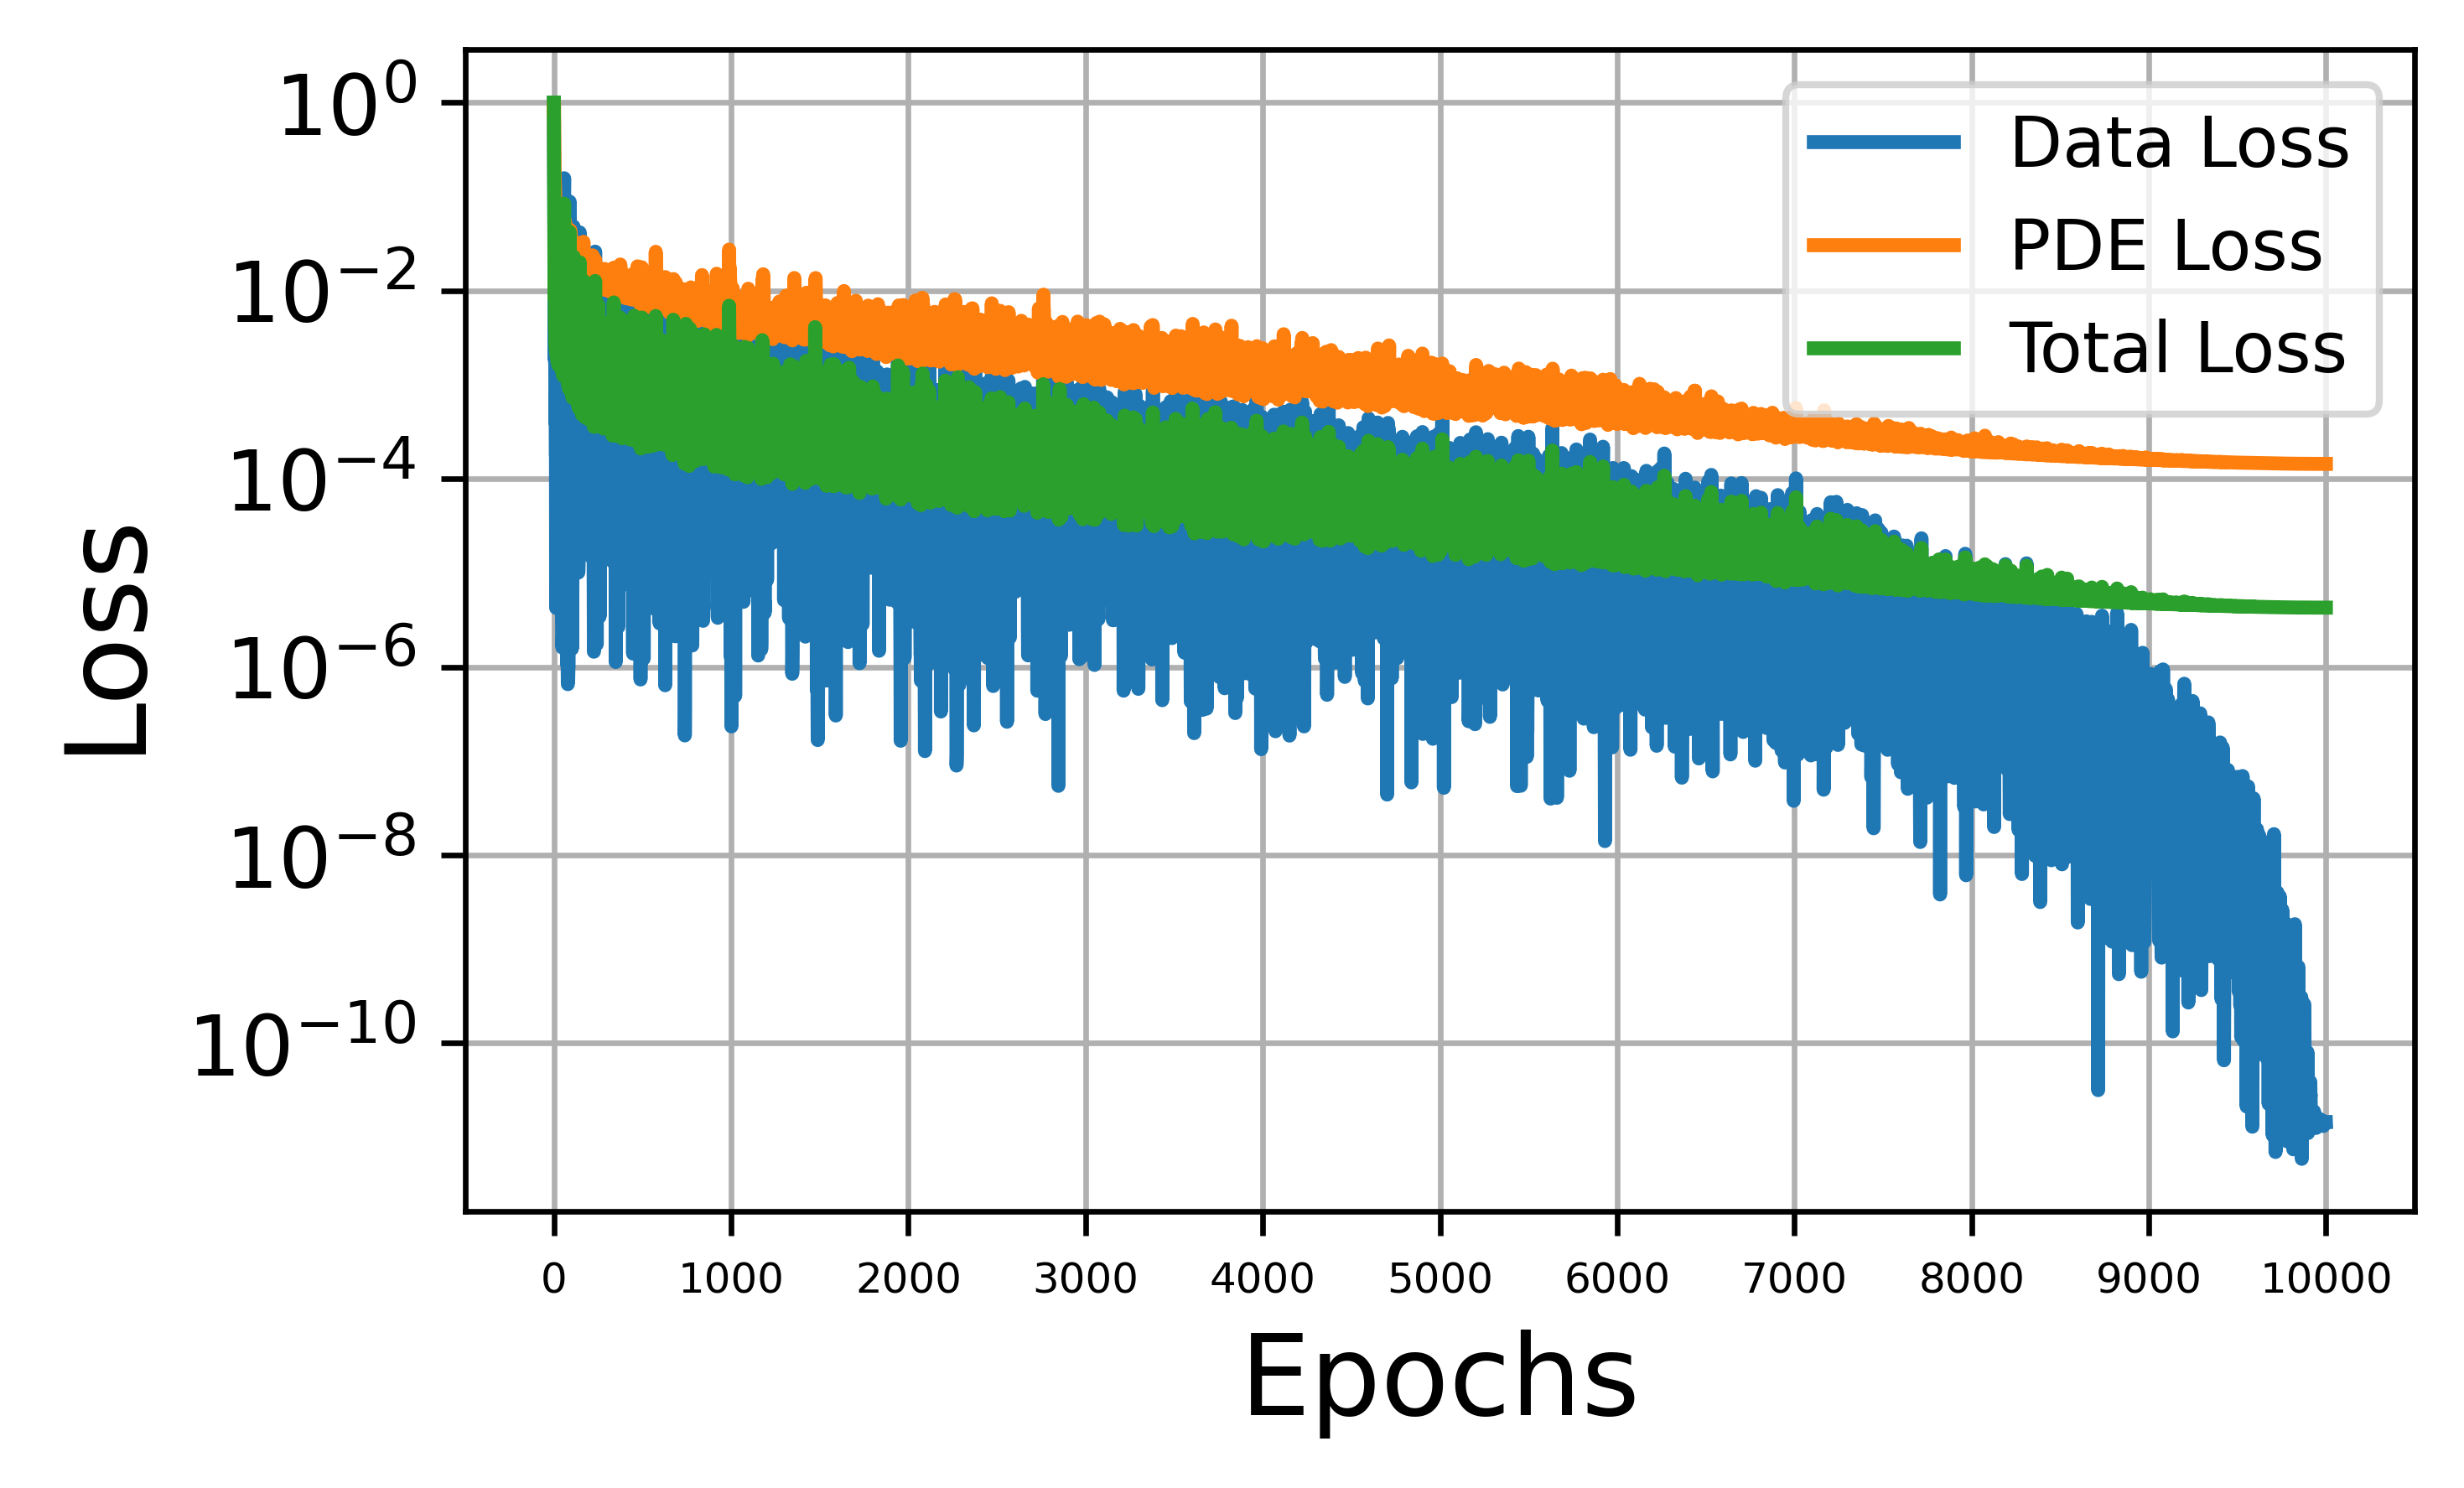

In [22]:
# Total Loss
fig = plt.figure(figsize=(5, 3), dpi=600)
ax = plt.axes()
ax.semilogy(data_loss / np.max(data_loss), linewidth=2, label='Data Loss')
ax.semilogy(eqn_loss / np.max(eqn_loss), linewidth=2, label='PDE Loss')
ax.semilogy(total_loss / np.max(total_loss), linewidth=2, label='Total Loss')

ax.set_xlabel('Epochs', fontsize=16)

plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(1000))

ax.set_ylabel('Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=6)
plt.grid()
plt.legend(loc='upper right')

## Inference

In [23]:
from tqdm import tqdm

pinn.eval()

# Predict travel times
preds = []
batch_size = 10000  # Process predictions in batches to avoid memory issues

# Calculate number of batches
n_batches = len(prediction_grid) // batch_size + (1 if len(prediction_grid) % batch_size != 0 else 0)

# Use tqdm to show progress
for i in tqdm(range(n_batches), desc="Inference"):
    # Get batch indices
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(prediction_grid))
    
    # Get batch data
    batch = prediction_grid[start_idx:end_idx]
    
    # Make predictions
    with torch.no_grad():
        batch_pred = pinn(batch)
    
    preds.append(batch_pred)

# Concatenate all predictions
pred = torch.cat(preds, dim=0)

Inference: 100%|██████████| 2700/2700 [00:01<00:00, 2502.93it/s]


In [24]:
# Find minimum values and their locations
min_pred = torch.min(pred)
min_tdata = torch.min(T_data)

# Get indices of minimum values
min_pred_idx = torch.where(pred == min_pred)[0]
min_tdata_idx = torch.where(T_data.reshape(-1) == min_tdata)[0]

print(f"Minimum predicted value: {min_pred.item():.6f}")
print(f"Minimum travel time value: {min_tdata.item():.6f}")

# Convert linear indices to 3D coordinates
def idx_to_coord(idx, nx, ny, nz):
    z = idx % nz
    y = (idx // nz) % ny
    x = idx // (ny * nz)
    return x, y, z

# Get coordinates of minimum values
pred_x, pred_y, pred_z = idx_to_coord(min_pred_idx[0].item(), nx, ny, nz)
tdata_x, tdata_y, tdata_z = idx_to_coord(min_tdata_idx[0].item(), nx, ny, nz)

print(f"\nPredicted minimum location (x,y,z): ({pred_x}, {pred_y}, {pred_z})")
print(f"Travel Time minimum location (x,y,z): ({tdata_x}, {tdata_y}, {tdata_z})")

Minimum predicted value: 0.050868
Minimum travel time value: 0.004964

Predicted minimum location (x,y,z): (145, 0, 108)
Travel Time minimum location (x,y,z): (292, 231, 221)


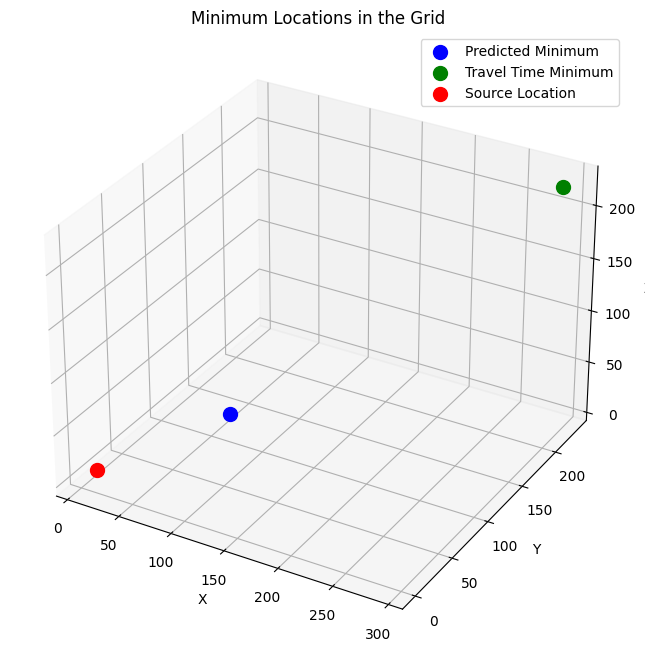

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the velocity model slices
ax.scatter(pred_x, pred_y, pred_z, color='b', s=100, label='Predicted Minimum')
ax.scatter(tdata_x, tdata_y, tdata_z, color='g', s=100, label='Travel Time Minimum')
ax.scatter(source_location[0], source_location[1], source_location[2], color='r', s=100, label='Source Location')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Minimum Locations in the Grid')
ax.legend()
plt.show()

## Prediction Uncertainty Quantification

In [ ]:
# pinn.train()
# diag = Diagonal(pinn)
# kfac = KFAC(pinn)

# # A rank-10 diagonal FiM approximation.
# for sample in range(1000):
    
#     loss, loss_eq, loss_data = system(pinn, params)

#     pinn.zero_grad()
#     loss.backward(retain_graph=True)

#     diag.update(batch_size=n_training_points)
#     kfac.update(batch_size=n_training_points)
    
#     efb = EFB(pinn, kfac.state)
#     efb.update(batch_size=n_training_points)

In [26]:
inf = INF(pinn, diag.state, kfac.state, efb.state)
inf.update(rank=1000)

100%|██████████| 7/7 [00:00<00:00, 34.58it/s]


In [28]:
estimator = diag
add = 5e3
multiply = 1e-3
estimator.invert(add, multiply)

In [29]:
num_samples = 10  # e.g., 5 Monte Carlo samples from the weight posterior
pinn.eval()      # Put model in eval mode (no dropout, BN in inference mode)

samples = []
sxr = np.zeros(num_samples)
syr = np.zeros(num_samples)
szr = np.zeros(num_samples)

# Set a batch_size that balances speed and memory usage
batch_size = 50_000  
n_points = len(prediction_grid)  # number of points in the flattened (x,y,z) grid
n_batches = n_points // batch_size + (1 if (n_points % batch_size) != 0 else 0)

with torch.no_grad():
    for i in tqdm(range(num_samples), desc="MC Sampling"):
        # 1) Sample new weights from the approximate posterior
        estimator.sample_and_replace()
        
        # 2) Predict in batches
        T_pred_list = []
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_points)
            
            batch_coords = prediction_grid[start_idx:end_idx]
            batch_pred = pinn(batch_coords)  # shape [batch_size, 1]
            
            # Move to CPU to free GPU memory, and store in a list
            T_pred_list.append(batch_pred.cpu())
        
        # 3) Concatenate all batch predictions
        T_pred_tensor = torch.cat(T_pred_list, dim=0)  # shape [n_points, 1]
        
        # 4) Reshape and convert to NumPy
        T_pred = T_pred_tensor.view(nx, ny, nz).numpy()
        
        # 5) Find the minimum travel time and location in this realization
        min_val = np.min(T_pred)
        ssx, ssy, ssz = np.where(T_pred == min_val)
        
        # 6) Save the travel-time field and the min location
        samples.append(T_pred)
        
        # For simplicity, store only the *first* index if there are ties
        sxr[i] = delta_x * ssx[0]
        syr[i] = delta_y * ssy[0]
        szr[i] = delta_z * ssz[0]

# Convert list of samples to array if needed
samples = np.array(samples)

MC Sampling: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


MC Sampling: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


All sampled hypocenters (x,y,z):
[[ 9.43143813 10.          4.94983278]
 [10.         10.          5.48494983]
 [10.         10.          5.98662207]
 [10.         10.          5.68561873]
 [10.         10.          5.35117057]
 [10.         10.          5.58528428]
 [10.         10.          5.4180602 ]
 [ 9.26421405 10.          5.51839465]
 [10.         10.          5.98662207]
 [ 9.93311037 10.          5.58528428]
 [10.         10.          2.87625418]
 [10.         10.          0.        ]
 [10.          8.22742475  6.38795987]
 [10.         10.          5.85284281]
 [10.         10.          5.65217391]
 [10.         10.          5.78595318]
 [ 9.96655518 10.          5.71906355]
 [10.         10.          5.78595318]
 [ 8.22742475 10.          3.94648829]
 [10.          9.63210702  1.77257525]
 [10.         10.          5.85284281]
 [ 9.09698997 10.          5.05016722]
 [10.         10.          5.4180602 ]
 [10.         10.          5.6187291 ]
 [10.         10.          5.38

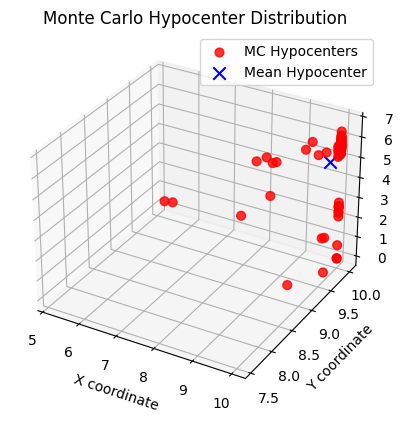

In [30]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

num_samples = 100  # e.g., 10 Monte Carlo samples
pinn.eval()       # Put model in eval mode (no dropout, BN in inference mode)

samples = []
sxr = np.zeros(num_samples)
syr = np.zeros(num_samples)
szr = np.zeros(num_samples)

# Set a batch_size that balances speed and memory usage
batch_size = 50_000
n_points = len(prediction_grid)  # number of points in the flattened (x,y,z) grid
n_batches = n_points // batch_size + (1 if (n_points % batch_size) != 0 else 0)

with torch.no_grad():
    for i in tqdm(range(num_samples), desc="MC Sampling"):
        # 1) Sample new weights from the approximate posterior
        estimator.sample_and_replace()
        
        # 2) Predict in batches
        T_pred_list = []
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_points)
            
            batch_coords = prediction_grid[start_idx:end_idx]
            batch_pred = pinn(batch_coords)  # shape [batch_size, 1]
            
            # Move to CPU to free GPU memory, and store in a list
            T_pred_list.append(batch_pred.cpu())
        
        # 3) Concatenate all batch predictions
        T_pred_tensor = torch.cat(T_pred_list, dim=0)  # shape [n_points, 1]
        
        # 4) Reshape and convert to NumPy
        T_pred = T_pred_tensor.view(nx, ny, nz).numpy()
        
        # 5) Find the minimum travel time and location in this realization
        min_val = np.min(T_pred)
        ssx, ssy, ssz = np.where(T_pred == min_val)
        
        # 6) Save the travel-time field (optional) and the min location
        samples.append(T_pred)
        
        # For simplicity, store only the *first* index if there are ties
        sxr[i] = delta_x * ssx[0]
        syr[i] = delta_y * ssy[0]
        szr[i] = delta_z * ssz[0]

# Convert list of samples to a 4D array if needed: (num_samples, nx, ny, nz)
samples = np.array(samples)

# -------------------------------------------------
#  A) Hypocenter Distribution in 3D
# -------------------------------------------------
locs = np.column_stack((sxr, syr, szr))  # shape [num_samples, 3]

mean_loc = locs.mean(axis=0)
std_loc = locs.std(axis=0)

print("All sampled hypocenters (x,y,z):")
print(locs)
print(f"\nMean hypocenter location: {mean_loc}")
print(f"Std dev in (x,y,z):       {std_loc}")

# 3D scatter plot of hypocenters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2], 
           color='r', s=40, alpha=0.8, label='MC Hypocenters')
ax.scatter(mean_loc[0], mean_loc[1], mean_loc[2], 
           color='b', s=80, marker='x', label='Mean Hypocenter')

ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.set_zlabel("Z coordinate")
ax.legend()
plt.title("Monte Carlo Hypocenter Distribution")
plt.show()

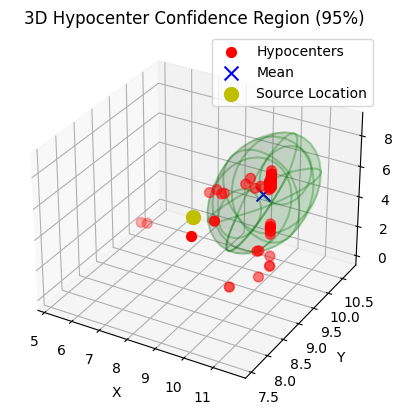

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ellipsoid(mean, cov, ax, n_std=2.4477, cage_color='g', alpha=0.1):
    """
    Plot a 3D ellipsoid representing the covariance matrix `cov` around the point `mean`.
    
    Args:
        mean (array-like): The center of the ellipsoid [x, y, z].
        cov  (array-like): The 3x3 covariance matrix.
        ax   (Axes3D): A 3D matplotlib axes object to draw the ellipsoid.
        n_std (float): The radius of the ellipsoid in terms of standard deviations 
                       (2.4477 ~ 95% confidence for 3D).
        cage_color (str): The color for the wireframe.
        alpha (float): Transparency of the ellipsoid surface.

    References:
        - "Plotting an ellipsoid" approach from stackoverflow.com/questions/7819498
    """
    # Ensure mean and cov are numpy arrays
    mean = np.array(mean)
    cov = np.array(cov)

    # Check if cov is positive-semidefinite
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # If any eigenvalues are zero or negative, the ellipsoid degenerates
    # We clamp them to a small positive value to avoid numerical issues
    eigenvalues = np.where(eigenvalues < 1e-12, 1e-12, eigenvalues)

    # Sort eigenvalues in descending order (not strictly necessary)
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # The radii of the ellipsoid (a,b,c) are n_std * sqrt(eigenvalues)
    radii = n_std * np.sqrt(eigenvalues)

    # Generate data for "unrotated" ellipsoid
    # Using spherical angles: u in [0,2pi], v in [0, pi]
    u = np.linspace(0, 2.0 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Scale points by the ellipsoid radii
    x *= radii[0]
    y *= radii[1]
    z *= radii[2]

    # Transform ellipsoid by eigenvectors (rotation) and then translate by `mean`
    # Combine the x, y, z coords in a matrix, rotate by eigenvectors, and shift
    for i in range(len(x)):
        for j in range(len(x)):
            xyz = np.array([x[i, j], y[i, j], z[i, j]])
            # Rotate
            xyz = eigenvectors @ xyz
            # Translate
            x[i, j], y[i, j], z[i, j] = xyz + mean

    # Plot the wireframe
    ax.plot_wireframe(x, y, z, rcount=6, ccount=6, color=cage_color, alpha=0.3)
    # Optionally, fill the surface if you want a solid ellipsoid:
    ax.plot_surface(x, y, z, color=cage_color, alpha=alpha, edgecolor='none')

# -----------------------------------------------------------------
# Example usage
# -----------------------------------------------------------------


# Compute mean & covariance
mean_loc = np.mean(locs, axis=0)      # shape [3]
cov_loc  = np.cov(locs.T)            # shape [3, 3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sampled points
ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2], color='r', s=50, label='Hypocenters')

# Plot the mean
ax.scatter(mean_loc[0], mean_loc[1], mean_loc[2],
           color='b', s=100, marker='x', label='Mean')

# Now draw the confidence ellipsoid around the mean
# n_std=2.4477 is ~95% conf. region in 3D
plot_ellipsoid(mean_loc, cov_loc, ax, n_std=2.4477, cage_color='g', alpha=0.1)
ax.scatter(source_location[0], source_location[1], source_location[2], color='y', s=100, label='Source Location')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Hypocenter Confidence Region (95%)")
ax.legend()
plt.show()

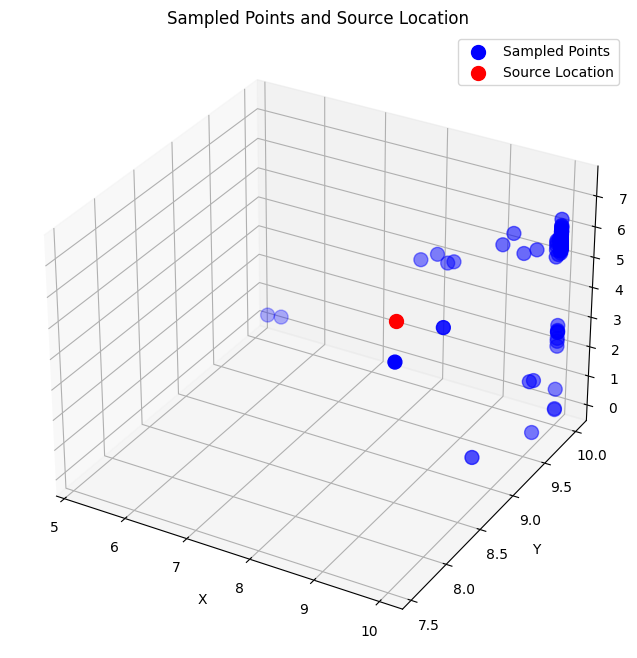

In [32]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the sampled points
ax.scatter(sxr, syr, szr, color='b', s=100, label='Sampled Points')

# Plot the source location
ax.scatter(source_location[0], source_location[1], source_location[2], color='r', s=100, label='Source Location')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Sampled Points and Source Location')
ax.legend()
plt.show()